In [1]:
#Loading up all libraries
import numpy as np  
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.models import Sequential  
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt  
import math  
# import cv2  
import datetime

In [2]:
# dimensions of our images.  
img_width, img_height = 254, 224  
   
top_model_weights_path = 'bottleneck_fc_model.h5'  
train_data_dir = 'data/train'  
validation_data_dir = 'data/validation'  
test_data_dir = 'data/test'
   
# number of epochs to train top model  
epochs = 100  
# batch size used by flow_from_directory and predict_generator  
batch_size = 50  

In [3]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet')  


In [4]:
datagen = ImageDataGenerator(rescale=1. / 255)  

In [5]:
start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 3500 images belonging to 5 classes.


C:\Users\arnav\AppData\Local\Temp\ipykernel_17824\620823525.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)


Time:  0:04:31.597666


In [6]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 75 images belonging to 5 classes.


C:\Users\arnav\AppData\Local\Temp\ipykernel_17824\2496864306.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_validation = vgg16.predict_generator(


Time:  0:00:06.490921


In [7]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict_generator(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1425 images belonging to 5 classes.


C:\Users\arnav\AppData\Local\Temp\ipykernel_17824\1258901172.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_test = vgg16.predict_generator(


Time:  0:02:08.865298


## Start from here

### Loading training, validation and testing

In [8]:
start = datetime.datetime.now()
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 3500 images belonging to 5 classes.
Time:  0:00:00.316550


In [9]:
generator_top = datagen_top.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 75 images belonging to 5 classes.


In [10]:
generator_top = datagen_top.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)  

Found 1425 images belonging to 5 classes.


### Training of model

In [11]:
num_classes

5

In [12]:
train_data.shape

(3500, 7, 7, 512)

In [13]:
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer='rmsprop',  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=6,  
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Epoch 1/6
70/70 [==============================] - 4s 44ms/step - loss: 1.7801 - accuracy: 0.6851 - val_loss: 0.2047 - val_accuracy: 0.9467
Epoch 2/6
70/70 [==============================] - 3s 41ms/step - loss: 0.3659 - accuracy: 0.8697 - val_loss: 0.0727 - val_accuracy: 1.0000
Epoch 3/6
70/70 [==============================] - 3s 41ms/step - loss: 0.1634 - accuracy: 0.9389 - val_loss: 0.5667 - val_accuracy: 0.8133
Epoch 4/6
70/70 [==============================] - 3s 42ms/step - loss: 0.1399 - accuracy: 0.9514 - val_loss: 0.0127 - val_accuracy: 1.0000
Epoch 5/6
70/70 [==============================] - 3s 41ms/step - loss: 0.0884 - accuracy: 0.9711 - val_loss: 0.0248 - val_accuracy: 1.0000
Epoch 6/6
2/2 [==============================] - 0s 9ms/step - loss: 0.0073 - accuracy: 1.0000
[INFO] accuracy: 100.00%
[INFO] Loss: 0.007262512110173702
Time:  0:00:18.631073


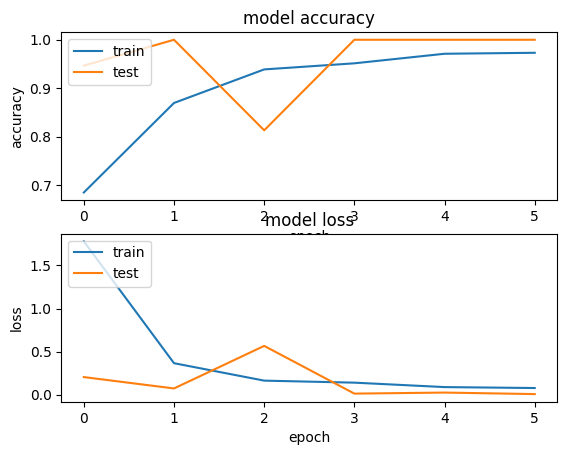

In [14]:
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

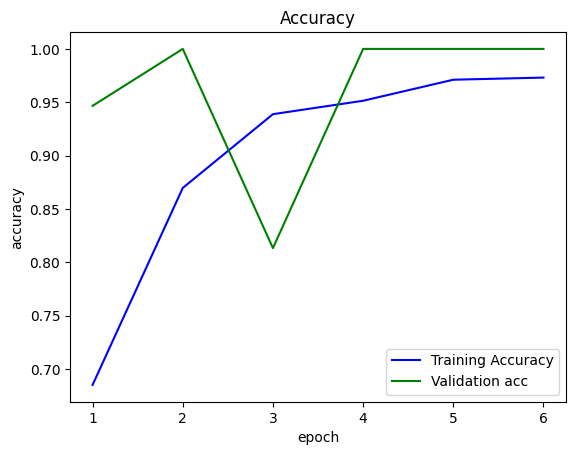

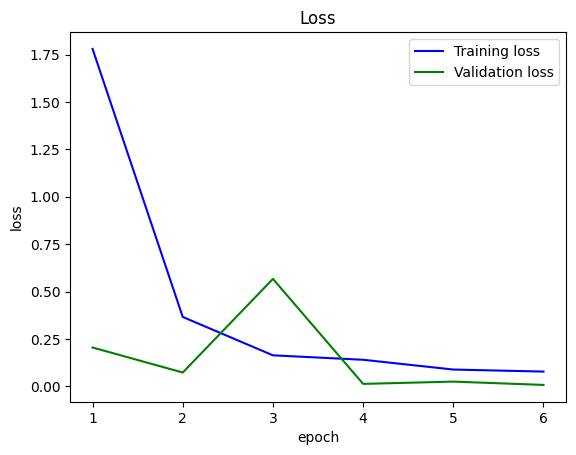

In [15]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'b', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch') 
plt.legend()
plt.figure()
plt.plot(epch, train_loss, 'b', label='Training loss')
plt.plot(epch, val_loss, 'g', label='Validation loss')
plt.title('Loss')
plt.ylabel('loss')  
plt.xlabel('epoch') 
plt.legend()
plt.show()

In [16]:
model.evaluate(test_data, test_labels)

45/45 [==============================] - 0s 6ms/step - loss: 0.1454 - accuracy: 0.9565


[0.14535242319107056, 0.956491231918335]

In [17]:
import matplotlib.image as mpimg

In [18]:
def read_image(file_path, resize=True):
    image_path = file_path

    orig = mpimg.imread(image_path)  

    
    image = load_img(image_path, target_size=(224, 224))  
    image = img_to_array(image)  


    if resize:
        image = image / 255  

    image = np.expand_dims(image, axis=0)
    return image

In [27]:
path = 'data/useData/h907.jpg'
image_pred = read_image(path)
Noteprediction = vgg16.predict(image_pred)  

 
model = Sequential()  
model.add(Flatten(input_shape=Noteprediction.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='softmax'))  

model.load_weights(top_model_weights_path)  

predict =  model.predict(Noteprediction)
class_predicted = np.argmax(predict, axis=1)

1/1 [==============================] - 0s 101ms/step


In [28]:
ID = class_predicted[0]  

class_dictionary = generator_top.class_indices  

map = {v: k for k, v in class_dictionary.items()}  

classification = map[ID]  

print("Image ID: {}, class: {}".format(ID, classification))  

Image ID: 1, class: Half


<class 'PIL.Image.Image'>
<class 'numpy.ndarray'>
(224, 224, 3)


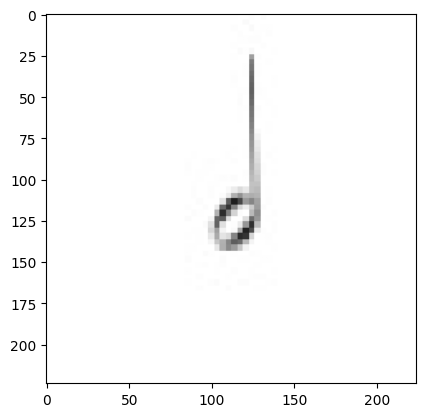

In [29]:
from keras.preprocessing import image

img_path = path
img = image.load_img(img_path, target_size=(224, 224))
print(type(img))

x = image.img_to_array(img)
print(type(x))
print(x.shape)
plt.imshow(x/255.)  


In [22]:
class_dictionary

{'Eight': 0, 'Half': 1, 'Quarter': 2, 'Sixteenth': 3, 'Whole': 4}